## Data Preprocessing Stage 2

In [1]:
# Importing all the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import csv

# Machine Learning models
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation file
import evaluation

In [2]:
# Loading the saved datasets from data preprocessing stage 1 notebook
train_data = pd.read_csv("proData/train_data.csv")
train_labels = pd.read_csv("proData/train_labels.csv")
test_data = pd.read_csv("proData/test_data.csv")
test_labels = pd.read_csv("proData/test_labels.csv")

In [3]:
numerical_vars = ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv']
categorical_vars = ['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [4]:
# Creating numerical and categorical datasets again
numerical_df_train = train_data[numerical_vars]
categorical_df_train = train_data[categorical_vars]

numerical_df_test = test_data[numerical_vars]
categorical_df_test = test_data[categorical_vars]

In [5]:
# Finding the correlation between numerical data and dependent feature
numeric_dict = {}
for feature in numerical_vars:
    cor, _ = pointbiserialr(train_labels['class'], numerical_df_train[feature])
    
    # Determining the direction of the association
    if cor > 0:
        direction = "Positive association"
    elif cor < 0:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Determining the strength of the association
    abs_corr = abs(cor)
    if abs_corr < 0.1:
        strength = "Weak"
    elif abs_corr < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"
    
    # saving the values in a dictionary
    numeric_dict[feature] = {
        'Correlation': cor,
        'Direction': direction,
        'Strength': strength
    }

In [6]:
# Checking the results
print(numeric_dict)

{'age': {'Correlation': 0.20524576867804045, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'bp': {'Correlation': 0.3339916774435051, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sg': {'Correlation': -0.6863014231440622, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'bgr': {'Correlation': 0.44567205273991545, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'bu': {'Correlation': 0.42746653285631875, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sc': {'Correlation': 0.3296929375882474, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sod': {'Correlation': -0.3542936810944146, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'pot': {'Correlation': 0.09366862225842577, 'Direction': 'Positive association', 'Strength': 'Weak'}, 'hemo': {'Correlation': -0.7507344471410045, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'pcv': {'Correlation': -0.7077555598989336, 'Direction': 'Negative a

In [7]:
# Finding the correlation between categorical data and dependent feature
categorical_dict = {}
for _, feature in enumerate(categorical_df_train):
    cont_table = np.array(pd.crosstab(train_labels['class'], categorical_df_train[feature], rownames=None,colnames=None))
    chi2, pval, dof, expected = chi2_contingency(cont_table)

    # Checking the conditions for positive, negative or no association
    observed_proportions = cont_table / np.sum(cont_table)
    expected_proportions = expected / np.sum(expected)
    
    if observed_proportions[0, 0] > expected_proportions[0, 0] and observed_proportions[1, 1] > expected_proportions[1, 1]:
        direction = "Positive association"
    elif observed_proportions[0, 1] > expected_proportions[0, 1] and observed_proportions[1, 0] > expected_proportions[1, 0]:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Calculate Cramer's V
    obs = np.sum(cont_table)
    minDim = min(cont_table.shape) - 1
    V = np.sqrt(chi2 / (obs * minDim))
    
    # Determine the strength of the association
    if V < 0.1:
        strength = "Weak"
    elif V < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"

    # saving the values in a dictionary
    categorical_dict[feature] = {
        'chi2': chi2,
        'pval': pval,
        'dof': dof,
        'Expected': expected,
        'Cramers_v': V,
        'Direction': direction,
        'Strength': strength
    }

In [8]:
# Checking the results
print(categorical_dict)

{'pc': {'chi2': 64.21402479806555, 'pval': 1.1161141716651841e-15, 'dof': 1, 'Expected': array([[170.5,  28.5],
       [170.5,  28.5]]), 'Cramers_v': 0.40167371192226525, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'pcc': {'chi2': 35.021170006464125, 'pval': 3.2614014589980876e-09, 'dof': 1, 'Expected': array([[182.,  17.],
       [182.,  17.]]), 'Cramers_v': 0.2966359544348556, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'ba': {'chi2': 16.81608187134503, 'pval': 4.1182817647649226e-05, 'dof': 1, 'Expected': array([[190.,   9.],
       [190.,   9.]]), 'Cramers_v': 0.20555160419783663, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'htn': {'chi2': 170.9938240295969, 'pval': 4.4885805193320224e-39, 'dof': 1, 'Expected': array([[138.5,  60.5],
       [138.5,  60.5]]), 'Cramers_v': 0.6554637470466651, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'dm': {'chi2': 155.02288464524142, 'pval': 1.3841806912356013e-35, 'dof': 1, 'Expe

In [9]:
# Creating a dataframe to save all the values calculated till now
results = []

In [10]:
# Iterate over numerical features
for feature, corr_data in numeric_dict.items():
    results.append([feature, 'Numeric', 'pointbiserialr', corr_data['Correlation'], corr_data['Direction'], corr_data['Strength']])

# Iterate over categorical features
for feature, corr_data in categorical_dict.items():
    results.append([feature, 'Categorical', 'Chi Square test with Cramers V', corr_data['Cramers_v'], corr_data['Direction'], corr_data['Strength']])

In [11]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Feature', 'Type', 'Correlation Type', 'Value', 'Direction', 'Strength'])

In [12]:
output_dir = 'Selected Features'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [13]:
# Save results to CSV
results_df.to_csv('Selected Features/correlation_results.csv', index=False)

In [14]:
# Initializing lists to store selected features based on direction
selected_features = {
    'Positive': [],
    'Negative': []
}

In [15]:
# Iterate over categorical features for Categorical associations
for feature, corr_data in categorical_dict.items():
    if corr_data['Strength'] in ['Moderate', 'Strong']:
        if corr_data['Direction'] == 'Positive association':
            selected_features['Positive'].append((feature, corr_data['Cramers_v']))
        elif corr_data['Direction'] == 'Negative association':
            selected_features['Negative'].append((feature, corr_data['Cramers_v']))

# Iterate over numerical features for Numeric associations
for feature, corr_data in numeric_dict.items():
    if corr_data['Strength'] in ['Moderate', 'Strong']:
        if corr_data['Direction'] == 'Positive association':
            selected_features['Positive'].append((feature, corr_data['Correlation']))
        elif corr_data['Direction'] == 'Negative association':
            selected_features['Negative'].append((feature, corr_data['Correlation']))

# Sort selected features by association strength
selected_features['Positive'].sort(key=lambda x: x[1], reverse=True)
selected_features['Negative'].sort(key=lambda x: x[1], reverse=True)

In [16]:
# Initialize final lists for top 10 features
top_features = []
used_features = set()  # To track used features

# Choose top 10 features each for positive and negative associations
count_positive = min(7, len(selected_features['Positive']))
count_negative = min(7, len(selected_features['Negative']))

# Add top positive features
for feature, value in selected_features['Positive'][:count_positive]:
    if feature not in used_features:
        top_features.append((feature, 'Positive', value))
        used_features.add(feature)

# Add top negative features
for feature, value in selected_features['Negative'][:count_negative]:
    if feature not in used_features:
        top_features.append((feature, 'Negative', value))
        used_features.add(feature)

In [17]:
# If one side has fewer than 5 features, add more from the opposite side to make it 6
if len(top_features) < 14:
    remaining_needed = 14 - len(top_features)

    # Add additional positive features
    additional_positive = [(feature, 'Positive', value) for feature, value in selected_features['Positive'] if feature not in used_features][:remaining_needed]
    top_features.extend(additional_positive)
    used_features.update([feature for feature, _, _ in additional_positive])

    # Add additional negative features if still needed
    if len(top_features) < 14:
        additional_negative = [(feature, 'Negative', value) for feature, value in selected_features['Negative'] if feature not in used_features][:remaining_needed]
        top_features.extend(additional_negative)

In [18]:
# Converting to DataFrame
df = pd.DataFrame(top_features, columns=['Feature', 'Association', 'Strength'])

In [19]:
# checking the selected features
print(df)

   Feature Association  Strength
0      htn    Positive  0.655464
1       dm    Positive  0.624103
2      bgr    Positive  0.445672
3       bu    Positive  0.427467
4       pe    Positive  0.418477
5       pc    Positive  0.401674
6      ane    Positive  0.375855
7    appet    Negative  0.447263
8      sod    Negative -0.354294
9       sg    Negative -0.686301
10     pcv    Negative -0.707756
11    hemo    Negative -0.750734
12      bp    Positive  0.333992
13      sc    Positive  0.329693


In [20]:
# Saving the selected features with results
df.to_csv('Selected Features/selected_features.csv', index=False)

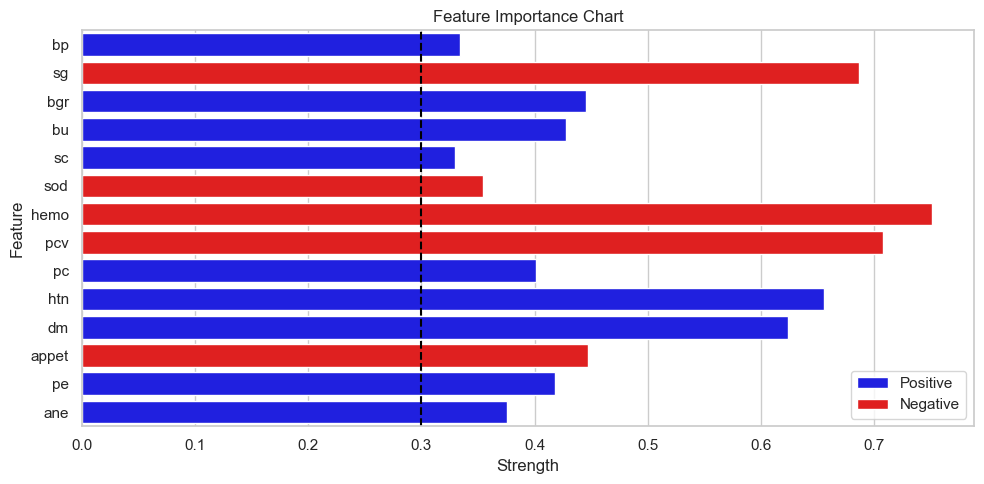

In [21]:
# Extract column names from the first dataset
column_names = train_data.columns

# Ensure the first column of df2 contains the row names that correspond to df1's columns
df_first_column = df.iloc[:, 0]

# Filter df2 to only include rows where the first column matches column names of df1
df_filtered = df[df_first_column.isin(column_names)]

# Reorder the rows in df2_filtered based on the order of df1's columns
df = df_filtered.set_index(df_first_column).reindex(column_names).dropna().reset_index()

# Creating a bar plot to visualization the results
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

df['Strength'] = df['Strength'].abs()

# Define barplot with hue for different colors for positive and negative associations
barplot = sns.barplot(x='Strength', y='Feature', hue='Association', data=df, palette={'Positive': 'blue', 'Negative': 'red'})

# Add vertical lines at -0.3 and 0.3
plt.axvline(x=0.3, color='black', linestyle='--')

# Add title and labels
plt.title('Feature Importance Chart')
plt.xlabel('Strength')
plt.ylabel('Feature')

# Adjust the legend
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

In [22]:
# Normalizing the numerical data
scaler = StandardScaler()
normalized_df_train = pd.DataFrame(scaler.fit_transform(numerical_df_train), columns=numerical_df_train.columns)
normalized_df_test = pd.DataFrame(scaler.transform(numerical_df_test), columns=numerical_df_test.columns)

In [23]:
print(normalized_df_train.head())
print(normalized_df_test.head())

        age        bp        sg       bgr        bu         sc        sod  \
0  0.548789  1.222478  0.258547 -0.243620  2.607778  13.117796 -14.723322   
1  0.548789  1.222478 -1.689897  5.096123  0.852784  -0.003542  -0.823359   
2  1.406416 -1.279533  0.258547 -0.721158 -0.076330  -0.379460   0.934739   
3 -0.063802  0.388474  0.258547 -0.663275 -0.716387  -0.272055   1.264382   
4 -1.288983  0.388474  1.232770 -0.605392 -0.592505  -0.397361   0.605096   

        pot      hemo       pcv  
0 -0.058529 -0.768733 -1.056335  
1 -0.271072 -0.547180 -0.683392  
2 -0.306496  1.557579  1.554264  
3  0.083166  0.708290  0.932693  
4  0.083166  0.302109  0.186807  
        age        bp        sg       bgr        bu        sc       sod  \
0  1.100121 -0.445529 -1.689897  1.825711  0.687608 -0.003542 -0.933240   
1  0.977603 -0.445529  0.258547  0.176034  0.026905 -0.200452 -0.823359   
2 -0.860170 -1.279533  0.258547 -0.417271 -0.138271 -0.289956  0.275452   
3 -1.043947 -0.445529  1.232770 -

In [24]:
# Concatenating the numeric and categorical datasets into train and test datasets
train_data = pd.concat([normalized_df_train, categorical_df_train], axis=1)
test_data = pd.concat([normalized_df_test, categorical_df_test], axis=1)

In [25]:
print(train_data.head())
print(test_data.head())

        age        bp        sg       bgr        bu         sc        sod  \
0  0.548789  1.222478  0.258547 -0.243620  2.607778  13.117796 -14.723322   
1  0.548789  1.222478 -1.689897  5.096123  0.852784  -0.003542  -0.823359   
2  1.406416 -1.279533  0.258547 -0.721158 -0.076330  -0.379460   0.934739   
3 -0.063802  0.388474  0.258547 -0.663275 -0.716387  -0.272055   1.264382   
4 -1.288983  0.388474  1.232770 -0.605392 -0.592505  -0.397361   0.605096   

        pot      hemo       pcv   pc  pcc   ba  htn   dm  cad  appet   pe  ane  
0 -0.058529 -0.768733 -1.056335  0.0  0.0  0.0  1.0  1.0  1.0    1.0  0.0  0.0  
1 -0.271072 -0.547180 -0.683392  0.0  0.0  1.0  1.0  1.0  0.0    1.0  0.0  0.0  
2 -0.306496  1.557579  1.554264  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
3  0.083166  0.708290  0.932693  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
4  0.083166  0.302109  0.186807  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
        age        bp        sg       bgr        bu

In [26]:
# Saving the train and test datasets
train_data.to_csv('proData/train_data.csv', index=False)
test_data.to_csv('proData/test_data.csv', index=False)

### Machine learning Models

In [27]:
# Fit logistic regression model
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [28]:
# Fit Gaussian Naive Bayes model
model_nb = GaussianNB()
model_nb.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [29]:
# Fit Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(train_data, train_labels)

DecisionTreeClassifier(random_state=42)

In [30]:
# Fit Support Vector Machine Classifier (SVM) model
model_svm = SVC(kernel='linear', C=1, random_state=42, probability=True)
model_svm.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [31]:
# Fit K-Nearest Neighbors model
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

### Feature Importance using shap

In [32]:
# Creating a dictionary for the trained models
ml_models = {
    'lr': model_lr,
    'nb': model_nb,
    'dt': model_dt,
    'svm': model_svm,
    'knn': model_knn
}

In [33]:
# Calculating the best features using shap library
shap_values_dict = {}
for name, model in ml_models.items():
    if name in ['nb', 'knn']:
        explainer = shap.KernelExplainer(model.predict, train_data)
        shap_values = explainer.shap_values(test_data)
    elif name == "dt":
        explainer = shap.TreeExplainer(model, train_data)
        shap_values = explainer.shap_values(test_data)
    else:
        explainer = shap.Explainer(model, train_data)
        shap_values = explainer(test_data)
    shap_values_dict[name] = shap_values

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/80 [00:00<?, ?it/s]

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/80 [00:00<?, ?it/s]

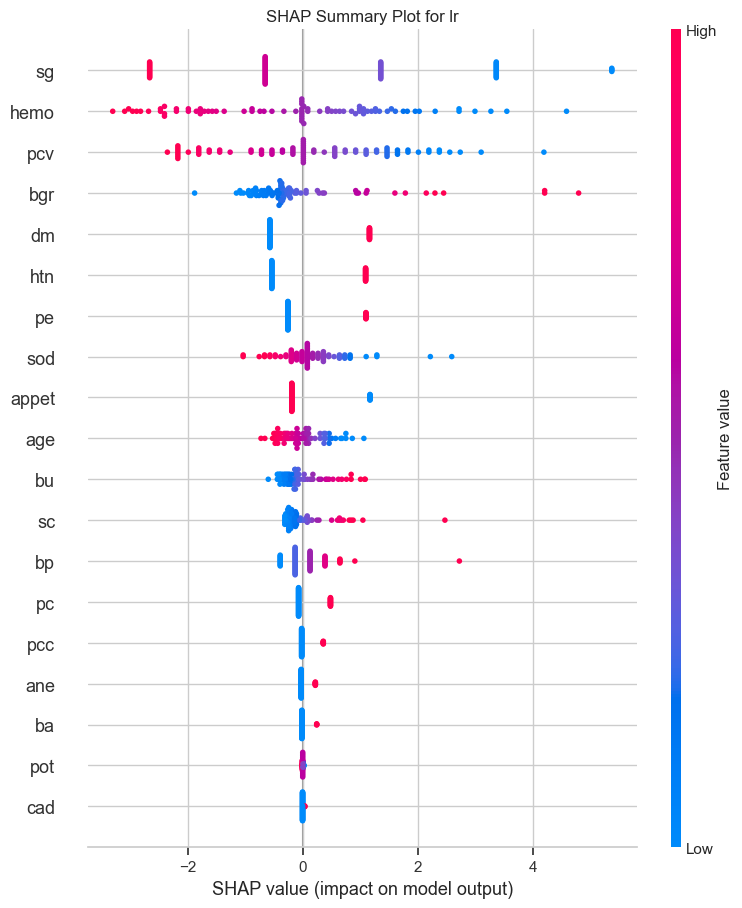

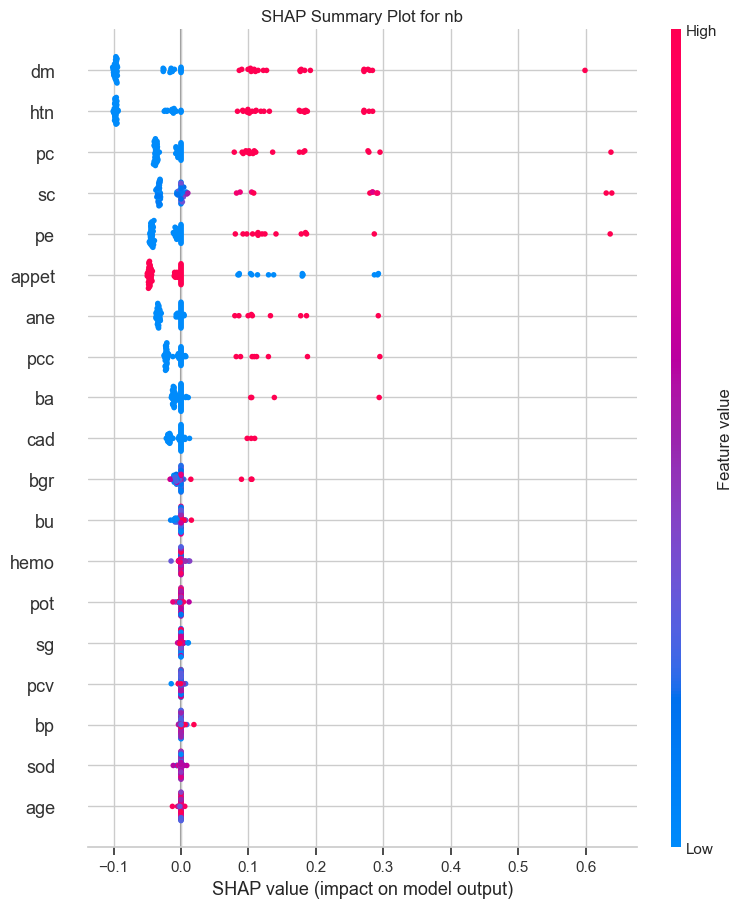

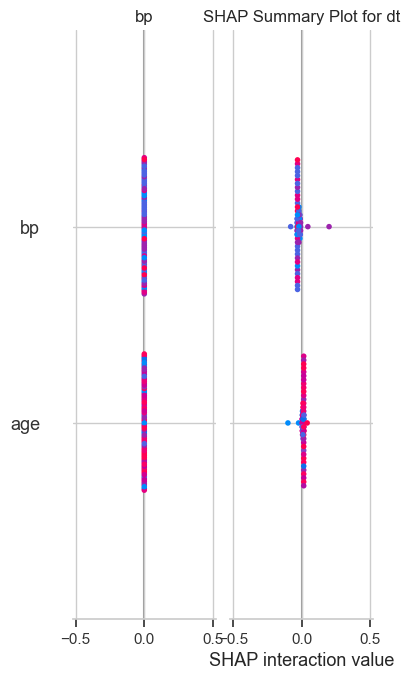

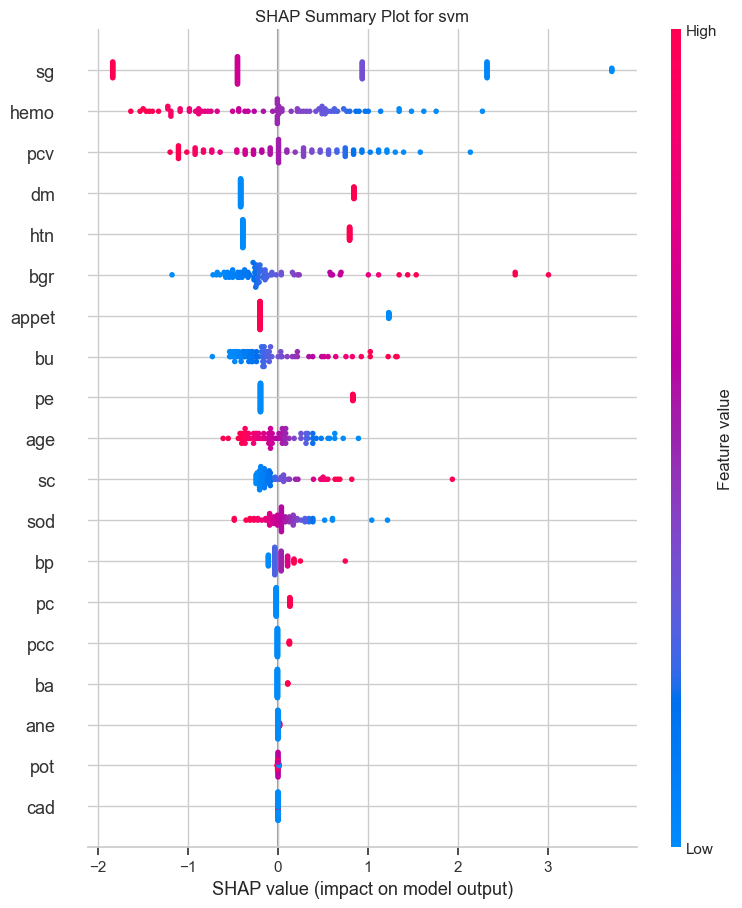

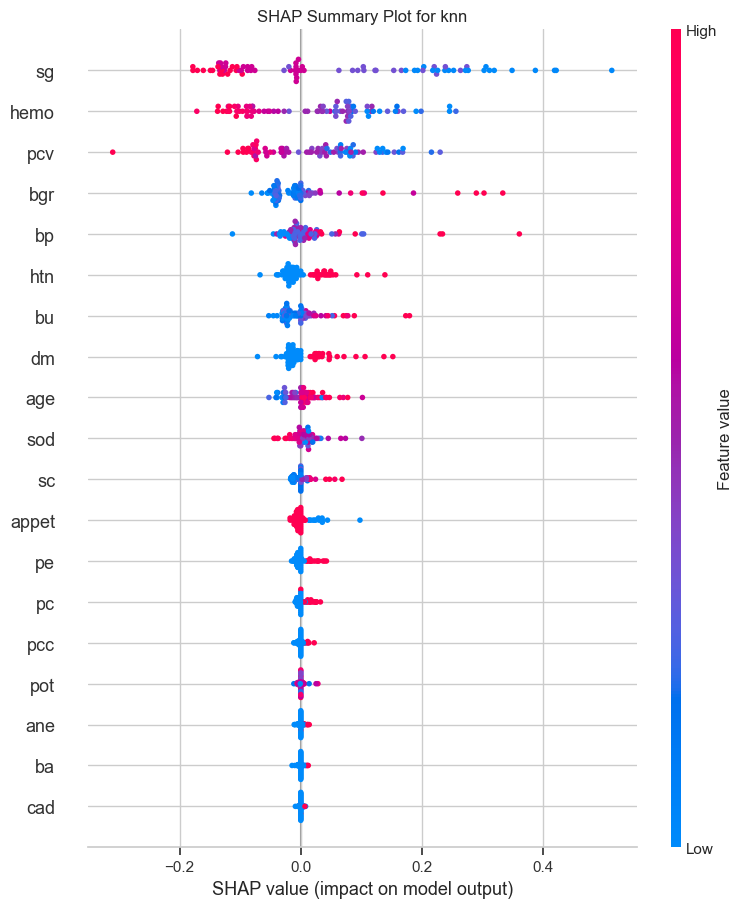

In [34]:
# Creating summary plots for all the machine learning models
for name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, test_data, show=False)
    plt.title(f'SHAP Summary Plot for {name}')
    plt.show()

In [35]:
# Applying mathematical operations on the calculated shap values to get the best features in order
feature_importance_df = pd.DataFrame(index=train_data.columns)

for name, shap_values in shap_values_dict.items():
    if hasattr(shap_values, 'values'):
        feature_importance = np.abs(shap_values.values).mean(axis=0)
    else:
        feature_importance = np.abs(shap_values).mean(axis=0)
    if name in ["dt", "knn"]:
        break
    else:
        feature_importance_df[name] = feature_importance

feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='mean_importance', ascending=False)

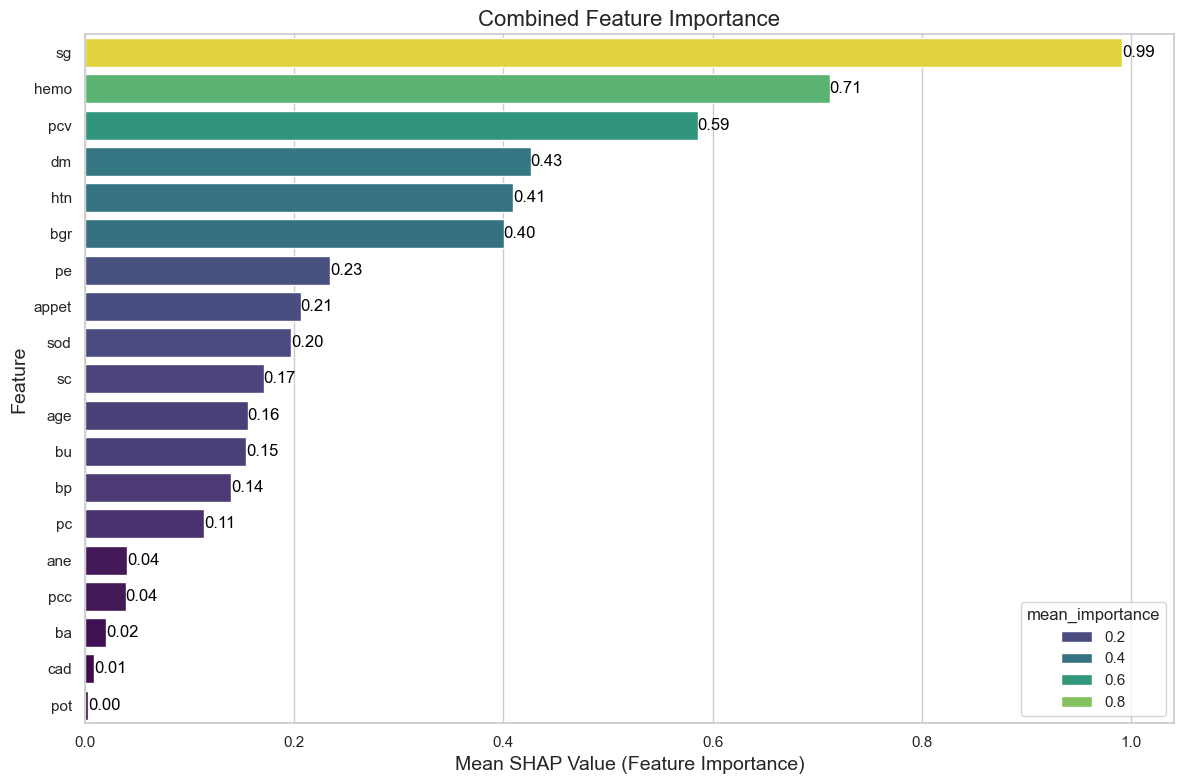

In [36]:
# Creating a best feature plot from shap values
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_df['mean_importance'], y=feature_importance_df.index, hue=feature_importance_df['mean_importance'], palette='viridis')
plt.title('Combined Feature Importance', fontsize=16)
plt.xlabel('Mean SHAP Value (Feature Importance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Annotate the bar plot with the importance values
for index, value in enumerate(feature_importance_df['mean_importance']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()

In [37]:
# Saving the best features from shap to a CSV file
best_features = feature_importance_df.index.tolist()
best_features_df = pd.DataFrame(best_features, columns=['feature_name'])
best_features_df.to_csv('Selected Features/shap_features.csv', index=False)

In [38]:
# Checking the dataframe
print(best_features_df)

   feature_name
0            sg
1          hemo
2           pcv
3            dm
4           htn
5           bgr
6            pe
7         appet
8           sod
9            sc
10          age
11           bu
12           bp
13           pc
14          ane
15          pcc
16           ba
17          cad
18          pot
